# Week 10 Assignment

In this week's lecture lab we examined two dimensionality reduction techniques, Principal Component Analysis (PCA) and the Autoencoder. In this assignment we will explore additional functionalities of the Autoencoder and demonstrate its incredible versatility.

# Part A - Imports and Data Prep

All required imports have been made for you.

In [2]:
# Import tensorflow - 
# You can use: 
# pip install tensorflow
# to install these packages
# make sure that you have seaborn version 0.11.0 installed 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy.random import normal

from torchvision import transforms
from torchvision.datasets import MNIST

from torch.utils.data import DataLoader
from tensorflow.keras.datasets.mnist import load_data
import random

from IPython.display import clear_output
from matplotlib import pyplot as plt

random.seed(100)
plt.style.use('seaborn')
from torch.utils.data import TensorDataset

# Part B - Noise Reduction

The autoencoder serves many purposes. You have already seen its ability to perform dimensionality reduction and now you will see how it can perform noise reduction. 

# Q1 List an additional functionality or potential use of an autoencoder (that has not been mentioned yet) in the space provided below. (5 marks)

Q1 Answer:

Autoencoders consist of 4 different components 

First an endcoder is used to reduced the input dimensionality by compressing the input data into an encoded representation..

Next, a bottleneck id used which is a layer than contains the compressed input data in the lowest possible dimensions of the input data.

A decoder is used to reconstruct the data form the encoded representation.

Lastly, the reconstruction loss measures the performance of the decoder by comparing the output to the input. 

Autoencoders are capable of learning nonlinear relations unlike PCA.

Autoencoders have many uses. They can be used for anomaly detection. An example of this is in an industrial setting for quality assurance purposes.

Another example is image engeration. A model could be given images of faces or scenories and can construct new images based on the inputs. This known as a variational autoencoder.

Lastly, autoencoders can be used to de-noise images which is the topic of this week's lab






# Q2 (30 marks)
To illustrate the ability of our autoencoder to reduce noise we will be using image data. Use the `load_data` function with the path attribute set to "mnist.npz". (Check documentation: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) You only care about the image data so you need to extract the training images from the imported data and get rid of the labels. Ensure your pixel values are between 0 and 1 and save this to the variable X_2

To simulate a noisy image, we will be adding white Gaussian noise to the data. To do this, you will need to use the normal function with a mean of 0 and a variance of 0.3. Cycle through the images in X_2, add noise, and save to a variable called X_2_noise.

Display the first image in X_2 and the first image in X_2_noise to see the effect of the noise you added. You can use the `sns.imshow` function for this.

In [3]:
x_2 = load_data(path='mnist.npz')[0][0]/255

mean = 0
variance = 0.3
sigma = variance**0.5
gauss = np.random.normal(mean, sigma, x_2.shape)
x_2_noise = x_2 + gauss



11493376/11490434 [==============================] - 9s 1us/step


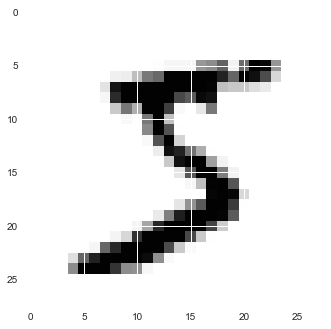

In [4]:
plt.imshow(x_2[0])

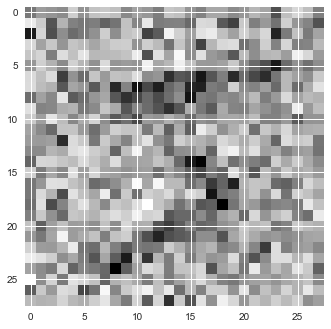

In [5]:
plt.imshow(x_2_noise[0])

# Q3 Create an autoencoder to de-noise the image. You are responsible for selecting an appropriate design for the autoencoder. To speed up your training, for each iteration, train on a small subset of the data. (40 marks)

In this setting, it is useful to train a slight variation on the autoencoder that takes a noisy image as input and has the original (non-noisy) image as its target. You can then use this model to de-noise future images. Note that you will have to take care of re-shaping the images into tensors as you use the `from_numpy` function. 

In [6]:


x_2_ten = torch.from_numpy(x_2)
x_2_noise_ten = torch.from_numpy(x_2_noise)

def plot_sample_img(img, name):
    img = img.view(1, 28, 28)
    save_image(img, './sample_{}.png'.format(name))

def live_plot(loss, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Cross Entropy Loss')

    plt.title(title)
    plt.show()

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=28**2, out_features=256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features=64),
            nn.ReLU(True))
        
        self.decoder = nn.Sequential(
            nn.Linear(in_features=64, out_features=256),
            nn.ReLU(True),
            nn.Linear(in_features=256, out_features=28**2),
            nn.Sigmoid())
        
        self.main = nn.Sequential(
            self.encoder,
            self.decoder)
        
      
    def forward(self, x):
      output = self.main(x.view(-1, 784))
      return x
        
loss_list = []
num_epochs = 30
batch_size = 64
learning_rate = 1e-3

model = autoencoder()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):

    epoch_loss = 0
    for index, (ndata, odata) in enumerate(zip(x_2_noise_ten, x_2_ten)): 

        # Zero the parameter gradients
        #optimizer.zero_grad()
        output = model(ndata.float())
        loss = criterion(output, odata)
        loss.requires_grad = True

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    loss_list.append(epoch_loss/batch_size)
    live_plot(np.array(loss_list)) 
    print(loss_list)


torch.save(model.state_dict(), './sim_autoencoder.pth')

C:\Users\Owner\AppData\Roaming\Python\Python38\site-packages\torch\autograd\__init__.py:130: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


KeyboardInterrupt: 

# Q4 (25 marks)
### Pass the noisy images through your trained denoiser. (Often in practice we would evaluate a de-noiser using new test data, but to keep things simple for this assignment we will re-use the noised training data.)

### Plot histograms of the image noise (i.e. all of the pixel-by-pixel differences from the original image) before and after the use of the denoiser (You can use a subset of the data to reduce the time it takes to generate). 

### Display three images: an image of a noisy sample, an image of the sample after denoising, and an image the corresponding original (noise-free) sample.


# Congratulations you have completed this week's assignment. Please remember to restart and run all cells before submitting.

In [ ]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda tensor:tensor/255),
    transforms.Lambda(lambda tensor:tensor + np.random.normal(0, 0.3**0.5, x_2.shape))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset[0][0], batch_size=batch_size, shuffle=True)